In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
# from pyod.models.gmm import GMM
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from pyod.models.iforest import IForest
# from pyod.models.gmm import GMM
# from sklearn.svm import OneClassSVM
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense
# import numpy as np
# from sklearn.model_selection import train_test_split


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Encoding Functions ------------------

def encode_pm25(pm25):
    """
    Encodes PM2.5 value into a numeric score:
      1: Good (0–30 µg/m³)
      2: Satisfactory (31–60 µg/m³)
      3: Moderate (61–90 µg/m³)
      4: Poor (91–120 µg/m³)
      5: Very Poor (121–250 µg/m³)
      6: Severe (251 µg/m³ and above)
    """
    if pm25 <= 30:
        return 1
    elif pm25 <= 60:
        return 2
    elif pm25 <= 90:
        return 3
    elif pm25 <= 120:
        return 4
    elif pm25 <= 250:
        return 5
    else:
        return 6

def encode_pm10(pm10):
    """
    Encodes PM10 value into a numeric score:
      1: Good (0–50 µg/m³)
      2: Satisfactory (51–100 µg/m³)
      3: Moderately Polluted (101–250 µg/m³)
      4: Poor (251–350 µg/m³)
      5: Very Poor (351–430 µg/m³)
      6: Severe (431 µg/m³ and above)
    """
    if pm10 <= 50:
        return 1
    elif pm10 <= 100:
        return 2
    elif pm10 <= 250:
        return 3
    elif pm10 <= 350:
        return 4
    elif pm10 <= 430:
        return 5
    else:
        return 6

def combined_air_quality_label(pm25, pm10):
    """
    Combines PM2.5 and PM10 numeric scores by taking the floor of the average.
    For example, if one pollutant is 'Severe' (6) and the other 'Moderate' (3),
    the average (4.5) is floored to 4, which we interpret as 'Poor'.
    """
    score_pm25 = encode_pm25(pm25)
    score_pm10 = encode_pm10(pm10)
    # Floor the average using integer division (works for positive numbers)
    combined_score = (score_pm25 + score_pm10) // 2
    return combined_score

# Optional mapping back to text label if needed
combined_labels = {
    1: "Good",
    2: "Satisfactory",
    3: "Moderate",
    4: "Poor",
    5: "Very Poor",
    6: "Severe"
}

def process_air_quality_data(df):
    """
    Processes a DataFrame containing 'pm25' and 'pm10' columns:
      - Encodes each pollutant into its numeric score.
      - Creates a combined score.
      - Retains only numeric columns.
    """
    df['pm25_numeric'] = df['pm25'].apply(encode_pm25)
    df['pm10_numeric'] = df['pm10'].apply(encode_pm10)
    df['combined_numeric'] = df.apply(
        lambda row: combined_air_quality_label(row['pm25'], row['pm10']),
        axis=1
    )
    df['combined_label'] = df['combined_numeric'].map(combined_labels)

    # Keep only numeric columns (if desired)
    df_numeric = df.select_dtypes(include=[np.number])
    return df_numeric

# ------------------ Misclassification Identification ------------------

def check_misclassification(row, pollutant):
    """
    Identifies if the anomaly detection for a row is a misclassification.

    Logic:
      - Computes the combined numeric air quality label using both 'pm2.5cnc' and 'pm10cnc' columns.
      - If an anomaly is flagged (column value 1) but the combined label is in a milder category (1, 2, or 3),
        it is a misclassification.
      - If no anomaly is flagged (0) but the combined label is in a worse category (4, 5, or 6),
        it is a misclassification.

    Returns:
      - True if misclassification, False otherwise.
    """
    # Compute combined numeric label from the pollutant values (assumes both columns are available)
    combined = combined_air_quality_label(row["pm2_5cnc"], row["pm10cnc"])

    # Determine the anomaly flag column (e.g., "Anomaly_pm25cnc_features" for "pm2.5cnc")
    anomaly_col = f"Anomaly_{pollutant.replace('.', '')}"
    anomaly_flag = row[anomaly_col]

    if anomaly_flag == 1 and combined in [1, 2, 3]:
        return True
    # elif anomaly_flag == 0 and combined in [4, 5, 6]:
    #     return True
    else:
        return False

In [3]:
def clean_and_prepare(df):
    """
    Cleans and prepares the dataframe:
    - Ensures datetime index
    - Handles missing values without affecting outlier detection
    - Creates time-based features
    - Drops non-numeric data
    """

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df["dt_time"] = pd.to_datetime(df["dt_time"])
        df = df.set_index("dt_time")

    # Remove non-relevant columns
    if "deviceid" in df.columns:
        df.drop(columns=["deviceid"], inplace=True)

    # Interpolate missing values using time-based method
    df.interpolate(method="time", inplace=True)

    # Create time-based features
    df["hour"] = df.index.hour
    df["sin_hour"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["cos_hour"] = np.cos(2 * np.pi * df["hour"] / 24)
    # df["day_of_week"] = df.index.dayofweek
    # df["sin_day"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
    # df["cos_day"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

    # Lag Features (Avoid NaNs)
    df["pm2.5_lag1"] = df["pm2_5cnc"].shift(1).bfill()
    df["pm2.5_lag2"] = df["pm2_5cnc"].shift(2).bfill()
    df["pm10_lag1"] = df["pm10cnc"].shift(1).bfill()
    df["pm10_lag2"] = df["pm10cnc"].shift(2).bfill()

    # Month & Seasonal Encoding
    df["month"] = df.index.month

    def get_season(month):
        if month in [1, 2]:
            return "Winter"
            return "Summer (Pre-Monsoon)"
        elif month in [6, 7, 8, 9]:
            return "Monsoon"
        else:
            return "Post-Monsoon (Autumn)"

    df["season"] = df["month"].apply(get_season)
    df["season_code"] = pd.Categorical(df["season"]).codes

    # Weekend Indicator
    # df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

    # Rate of Change Features
    # df["pm2.5_diff"] = df["pm2.5cnc"].diff().fillna(0)  # Avoid NaNs
    # df["pm10_diff"] = df["pm10cnc"].diff().fillna(0)  # Avoid NaNs

    # Drop Non-Numeric Columns
    df.drop(columns=["season"], inplace=True)
    # df.drop(columns=["hour"], inplace=True)
    # df.drop(columns=["minute"], inplace=True)


    # Final NaN Handling (Ensures No NaNs Remain)
    df.fillna(method="ffill", inplace=True)  # Forward-fill
    df.fillna(method="bfill", inplace=True)  # Back-fill

    return df


In [4]:
def run_isoforest(train_data):
    """
    Trains an Isolation Forest on the given training data.
    Converts detected anomalies (-1) to normal (1) only if they fall within safe AQI ranges:
      - For 'pm2.5cnc': safe range is 0 to 90.
      - For 'pm10cnc': safe range is 0 to 350.
    Returns: (model, scores, labels)
    """
    # Train the model
    model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    model.fit(train_data)

    # Get outputs from Isolation Forest
    scores = model.decision_function(train_data)  # Higher => more normal
    labels = model.predict(train_data)              # 1 => normal, -1 => anomaly

    # Define safe range mask based on available pollutant columns
    # safe_range_mask = None
    # if 'pm2.5cnc' in train_data.columns and 'pm10cnc' in train_data.columns:
    #     mask_pm25 = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 90)
    #     mask_pm10 = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
    #     safe_range_mask = mask_pm25 & mask_pm10
    # elif 'pm2.5cnc' in train_data.columns:
    #     safe_range_mask = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 90)
    # elif 'pm10cnc' in train_data.columns:
    #     safe_range_mask = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)

    # # For rows flagged as anomaly (-1) but within the safe range, force them to normal (1)
    # if safe_range_mask is not None:
    #     labels = np.where((labels == -1) & safe_range_mask, 1, labels)

    return model, scores, labels


def run_svm(train_data):
    """
    Trains a One-Class SVM on the given training data.
    Converts detected anomalies (-1) to normal (1) only if they fall within safe AQI ranges:
      - For 'pm2.5cnc': safe range is 0 to 90.
      - For 'pm10cnc': safe range is 0 to 350.
    Returns: (model, scores, labels)
    """
    # Train the model
    model = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
    model.fit(train_data)

    # Get outputs from One-Class SVM
    scores = model.decision_function(train_data)  # Higher => more normal
    labels = model.predict(train_data)              # 1 => normal, -1 => anomaly

    # Define safe range mask based on available pollutant columns
    safe_range_mask = None
    if 'pm2.5cnc' in train_data.columns and 'pm10cnc' in train_data.columns:
        mask_pm25 = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 250)
        mask_pm10 = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)
        safe_range_mask = mask_pm25 & mask_pm10
    elif 'pm2.5cnc' in train_data.columns:
        safe_range_mask = (train_data["pm2.5cnc"] >= 0) & (train_data["pm2.5cnc"] <= 250)
    elif 'pm10cnc' in train_data.columns:
        safe_range_mask = (train_data["pm10cnc"] >= 0) & (train_data["pm10cnc"] <= 350)

    # For rows flagged as anomaly (-1) but within the safe range, force them to normal (1)
    if safe_range_mask is not None:
        labels = np.where((labels == -1) & safe_range_mask, 1, labels)

    return model, scores, labels

def split_data_random(df):
    """
    Splits the dataset into train (70%), test (20%), and validation (10%).

    Parameters:
    df (DataFrame): The dataset to split.

    Returns:
    train (DataFrame): 70% of data for training.
    test (DataFrame): 20% of data for testing.
    validation (DataFrame): 10% of data for final validation.
    """
    train, temp = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% temp
    test, validation = train_test_split(temp, test_size=1/3, random_state=42)  # 20% test, 10% validation
    return train, test, validation

def split_data(df):
    """
    Splits the dataset into train (70%), test (20%), and validation (10%)
    in a historical order (earliest to latest).

    Parameters:
    df (DataFrame): The dataset to split. Assumes it is sorted by timestamp.

    Returns:
    train (DataFrame): First 70% of data for training.
    test (DataFrame): Next 20% of data for testing.
    validation (DataFrame): Final 10% of data for validation.
    """
    # Ensure data is sorted by timestamp (assuming a 'timestamp' column exists)
    df = df.sort_values(by='dt_time')

    # Compute split indices
    n = len(df)
    train_end = int(n * 0.7)
    test_end = int(n * 0.9)  # 70% train + 20% test = 90%, remaining 10% is validation

    # Split sequentially
    train = df.iloc[:train_end]
    test = df.iloc[train_end:test_end]
    validation = df.iloc[test_end:]

    return train, test, validation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_feature_design(df, pollutant_1, pollutant_2, location_score, lambda_decay=0.1, epsilon=1e-6):
    """
    Applies feature design calculations based on the provided formula.

    Parameters:
      - df: DataFrame containing air quality data.
      - pollutant_1: First pollutant column (e.g., 'pm2.5cnc').
      - pollutant_2: Second pollutant column (e.g., 'pm10cnc').
      - location_score: Site-specific importance score (S_location).
      - lambda_decay: Decay factor for time-based weighting (T_weight).
      - epsilon: A small constant to avoid division by zero in R_change calculation.

    Returns:
      - DataFrame with the calculated feature 'F_t'.
    """
    # Calculate Z-scores for PM2.5 and PM10
    df['Z_pm25'] = (df[pollutant_1] - df[pollutant_1].rolling(window=24).mean()) / df[pollutant_1].rolling(window=24).std()
    df['Z_pm10'] = (df[pollutant_2] - df[pollutant_2].rolling(window=24).mean()) / df[pollutant_2].rolling(window=24).std()

    # Calculate weighted contribution of PM2.5 and PM10
    # Here, you would dynamically calculate the weights (W_pm25, W_pm10) as per your logic
    df['W_pm25'] = 1  # Placeholder: Replace with dynamic weight calculation logic
    df['W_pm10'] = 1  # Placeholder: Replace with dynamic weight calculation logic

    # Calculate Time-based weight (T_weight) with decay factor
    df['T_weight'] = np.exp(-lambda_decay * (df.index - df.index.min()).days)

    # Calculate recent change rate (R_change) for PM2.5 and PM10
    df['R_change'] = ((df[pollutant_1] - df[pollutant_1].shift(1)) / (df[pollutant_1].shift(1) + epsilon)) + \
                     ((df[pollutant_2] - df[pollutant_2].shift(1)) / (df[pollutant_2].shift(1) + epsilon))

    # Calculate Feature F_t based on the formula provided
    df['F_t'] = ((df['Z_pm25'] * df['W_pm25']) + (df['Z_pm10'] * df['W_pm10']) +
                 (location_score * df['T_weight']) + df['R_change'])

    return df

def process_and_plot_anomalies(df,model_type, pollutant, location_score=1):
    """
    Generic anomaly detection pipeline for PM2.5 or PM10 with feature design formula.

    Parameters:
      - file_path: Path to the CSV file containing the air quality data.
      - model_type: One of {"svm", "iforest", "gmm", "dbscan", "lstm"}.
      - pollutant: Either "pm2.5cnc" or "pm10cnc".
      - location_score: Site-specific importance score (S_location).

    Returns:
      - Updated DataFrame with anomaly and misclassification labels.
    """

    # Ensure valid pollutant name
    if pollutant not in ["pm2_5cnc", "pm10cnc"]:
        raise ValueError("Invalid pollutant. Choose 'pm2.5cnc' or 'pm10cnc'.")

    # Define the anomaly column name (e.g., "Anomaly_pm25cnc")
    anomaly_col = f"Anomaly_{pollutant.replace('.', '')}"

    # Data Cleaning & Preparation
    df = clean_and_prepare(df)
    train, test, validation = split_data_random(df)

    # Select the correct model function
    model_functions = {
        # "svm": run_svm,
        "iforest": run_isoforest,
        # Additional models can be added here as needed.
    }

    if model_type not in model_functions:
        raise ValueError("Invalid model_type. Choose from 'svm', 'iforest', 'gmm', 'dbscan', 'lstm'.")

    # Extract the pollutant column for anomaly detection
    train_data = train[[pollutant]]
    test_data = test[[pollutant]]
    val_data = validation[[pollutant]]

    # Run anomaly detection model on train, test, and validation splits
    model, train_scores, train_labels = model_functions[model_type](train_data)
    _, test_scores, test_labels = model_functions[model_type](test_data)
    _, val_scores, val_labels = model_functions[model_type](val_data)

    # Store anomaly labels (1 = anomaly, 0 = normal)
    train["Anomaly"] = (train_labels == -1).astype(int)
    test["Anomaly"] = (test_labels == -1).astype(int)
    validation["Anomaly"] = (val_labels == -1).astype(int)

    # Merge anomaly labels back into the original DataFrame
    df[anomaly_col] = 0  # Default: no anomaly
    df.loc[train.index, anomaly_col] = train["Anomaly"]
    df.loc[test.index, anomaly_col] = test["Anomaly"]
    df.loc[validation.index, anomaly_col] = validation["Anomaly"]

    # If using IsoForest, copy predicted anomaly column to "Anomaly_IsoForest" for metric calculations
    if model_type == 'iforest':
        df["Anomaly_IsoForest"] = df[anomaly_col]

    # Apply feature design formula to calculate F_t
    df = calculate_feature_design(df, "pm2_5cnc", "pm10cnc", location_score)

    # Integrate misclassification identification
    misclass_col = f"Misclassification_{pollutant.replace('.', '')}"
    df[misclass_col] = df.apply(lambda row: check_misclassification(row, pollutant), axis=1)

    # ------------------ Plotting ------------------
    plt.figure(figsize=(12, 5))
    plt.scatter(train.index, train[pollutant], c=train["Anomaly"], cmap="coolwarm", label="Train", s=15)
    plt.title(f"{pollutant.upper()} Concentration Anomalies ({model_type.upper()})")
    plt.xlabel("Time")
    plt.ylabel(f"{pollutant} Concentration")
    plt.legend()
    plt.show()

    # Print anomaly counts for each split
    print(f"Train anomalies ({pollutant}): {train['Anomaly'].sum()}")
    print(f"Test anomalies ({pollutant}): {test['Anomaly'].sum()}")
    print(f"Validation anomalies ({pollutant}): {validation['Anomaly'].sum()}")

    # Print misclassification count
    total_misclassified = df[misclass_col].sum()
    print(f"Total misclassifications for {pollutant}: {total_misclassified}")

    return df


In [6]:
df = pd.read_csv("csvs/site_104_data.csv", parse_dates=["dt_time"])

In [7]:
df

,id,dt_time,pm2_5cnc,pm10cnc,deviceid
0,1,2021-10-26 15:00:00,352.34,NaN,site_104
1,2,2021-10-26 15:30:00,327.90,NaN,site_104
2,3,2021-10-26 16:00:00,77.60,NaN,site_104
3,4,2021-10-26 16:30:00,14.85,NaN,site_104
4,5,2021-10-26 17:00:00,79.68,NaN,site_104
...,...,...,...,...,...
59246,59247,2025-03-13 22:00:00,89.12,163.44,site_104
59247,59248,2025-03-13 22:30:00,89.39,166.28,site_104
59248,59249,2025-03-13 23:00:00,108.27,180.14,site_104
59249,59250,2025-03-13 23:30:00,103.26,223.81,site_104


C:\Users\21til\AppData\Local\Temp\ipykernel_17988\90869505.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # Forward-fill
C:\Users\21til\AppData\Local\Temp\ipykernel_17988\90869505.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)  # Back-fill


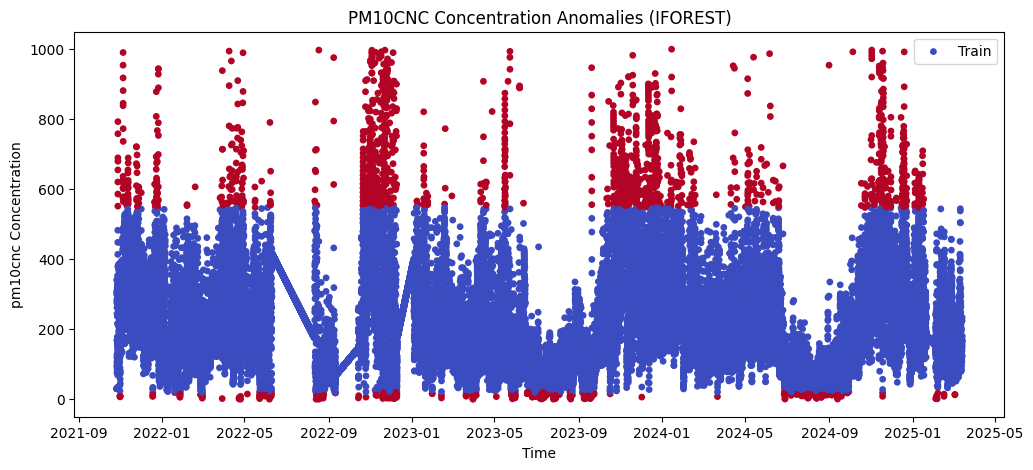

Train anomalies (pm10cnc): 2074
Test anomalies (pm10cnc): 590
Validation anomalies (pm10cnc): 294
Total misclassifications for pm10cnc: 723


C:\Users\21til\AppData\Local\Temp\ipykernel_17988\90869505.py:65: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill", inplace=True)  # Forward-fill
C:\Users\21til\AppData\Local\Temp\ipykernel_17988\90869505.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)  # Back-fill


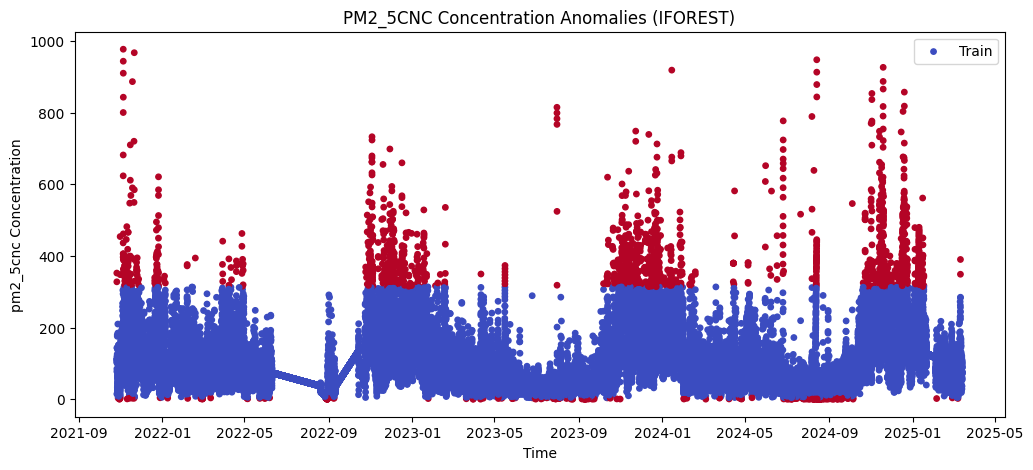

Train anomalies (pm2_5cnc): 2072
Test anomalies (pm2_5cnc): 592
Validation anomalies (pm2_5cnc): 296
Total misclassifications for pm2_5cnc: 646


In [8]:
df10iforest = process_and_plot_anomalies(df,model_type="iforest", pollutant="pm10cnc")
df25iforest = process_and_plot_anomalies(df,model_type="iforest", pollutant="pm2_5cnc")

In [9]:
df10iforest

,id,pm2_5cnc,pm10cnc,hour,sin_hour,cos_hour,pm2.5_lag1,pm2.5_lag2,pm10_lag1,pm10_lag2,...,Anomaly_pm10cnc,Anomaly_IsoForest,Z_pm25,Z_pm10,W_pm25,W_pm10,T_weight,R_change,F_t,Misclassification_pm10cnc
dt_time,,,,,,,,,,,,,,,,,,,,,
2021-10-26 15:00:00,1,352.34,30.12,15,-0.707107,-0.707107,352.34,352.34,30.12,30.12,...,0,0,NaN,NaN,1,1,1.000000e+00,NaN,NaN,False
2021-10-26 15:30:00,2,327.90,30.12,15,-0.707107,-0.707107,352.34,352.34,30.12,30.12,...,0,0,NaN,NaN,1,1,1.000000e+00,-0.069365,NaN,False
2021-10-26 16:00:00,3,77.60,30.12,16,-0.866025,-0.500000,327.90,352.34,30.12,30.12,...,0,0,NaN,NaN,1,1,1.000000e+00,-0.763342,NaN,False
2021-10-26 16:30:00,4,14.85,30.12,16,-0.866025,-0.500000,77.60,327.90,30.12,30.12,...,0,0,NaN,NaN,1,1,1.000000e+00,-0.808634,NaN,False
2021-10-26 17:00:00,5,79.68,30.12,17,-0.965926,-0.258819,14.85,77.60,30.12,30.12,...,0,0,NaN,NaN,1,1,1.000000e+00,4.365656,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-13 22:00:00,59247,89.12,163.44,22,-0.500000,0.866025,95.25,89.17,180.12,167.90,...,0,0,1.353025,0.870691,1,1,2.558945e-54,-0.156962,2.066754,False
2025-03-13 22:30:00,59248,89.39,166.28,22,-0.500000,0.866025,89.12,95.25,163.44,180.12,...,0,0,1.253705,0.924459,1,1,2.558945e-54,0.020406,2.198570,False
2025-03-13 23:00:00,59249,108.27,180.14,23,-0.258819,0.965926,89.39,89.12,166.28,163.44,...,0,0,2.011809,1.355551,1,1,2.558945e-54,0.294563,3.661923,False


In [10]:
def plot_zoomed_anomalies(df, start_date, end_date, pollutant):
    # List possible column name formats for the anomaly column


    anomaly_col = 'Anomaly_pm10cnc'


    # Filter DataFrame for the specified date range
    df_filtered = df.loc[start_date:end_date]

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered.index, df_filtered[pollutant], label=pollutant, color='blue')

    # Highlight anomalies using the found anomaly column
    anomalies = df_filtered[df_filtered[anomaly_col] == 1]
    plt.scatter(anomalies.index, anomalies[pollutant], color='red', label="Anomaly", marker='o')

    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(f"Zoomed Anomalies for {pollutant}")
    plt.legend()
    plt.grid()
    plt.show()


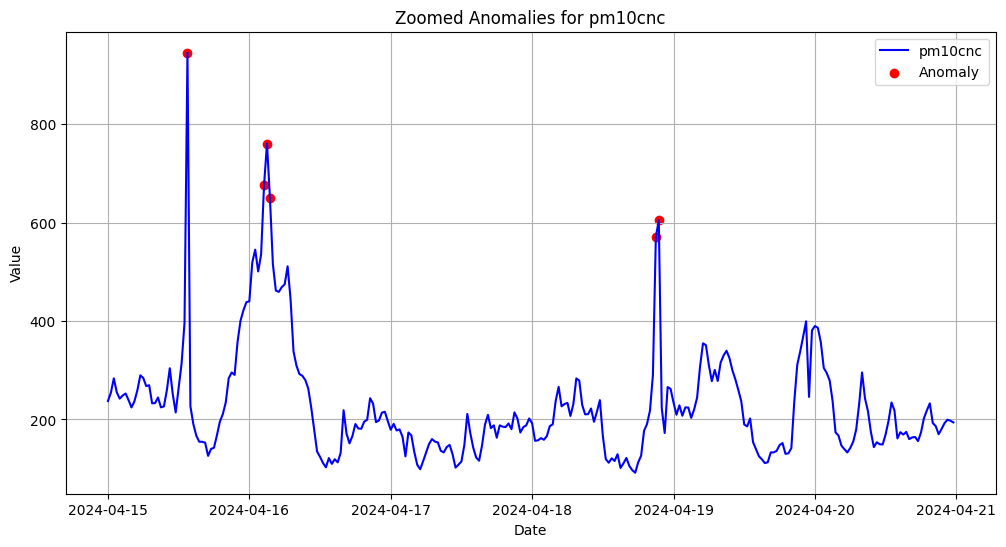

In [11]:
plot_zoomed_anomalies(df10iforest,"2024-04-15","2024-04-20","pm10cnc")